In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from drawdata import ScatterWidget
from qbstyles import mpl_style

mpl_style(dark=True)

In [81]:
def model_line(model, X, y, color_dp3d="black", color_dp2d="red", color_line2d="white", color_line3d="white", alpha=0.5):
    if X.shape[1] == 1:  # 2D Case
        plt.scatter(X.iloc[:, 0], y, marker=".", color=color_dp2d, label="Data")
        y_pred = model.predict(X).flatten()
        plt.plot(X.iloc[:, 0], y_pred, color=color_line2d, label="Model Prediction")
        plt.xlabel(X.columns[0])
        plt.ylabel(y.name)
        plt.legend()

    elif X.shape[1] == 2:  # 3D Case
        plt.ion()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], y, color=color_dp3d, label="Data", marker=".")

        X_vals = X.iloc[:, 0]
        Y_vals = X.iloc[:, 1]
        Z_vals = model.predict(X).flatten()
        ax.plot_trisurf(X_vals, Y_vals, Z_vals, color=color_line3d, alpha=alpha)

        ax.set_xlabel(X.columns[0])
        ax.set_ylabel(X.columns[1])
        ax.set_zlabel(y.name)
        plt.legend()
        plt.show()

    else:
        raise ValueError("Only 1D or 2D features are supported.")


def predictor_line(model, X, y, dot_color="yellow", line_color="cyan", marker="."):
    pred = model.predict(X).flatten()
    y_true = y.to_numpy().flatten()
    start = min(y_true.min(), pred.min())
    end = max(y_true.max(), pred.max())
    line = np.linspace(start, end, 100)

    plt.scatter(y_true, pred, marker=marker, color=dot_color)
    plt.plot(line, line, color=line_color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()


def model_equation(model, feature_names, target_label, variable_as_name=False):
    # Check if model is Keras (has get_weights)
    if hasattr(model, "get_weights"):
        weights = model.get_weights()
        coef = weights[0].flatten()
        intercept = weights[1].item()
    # Else assume it's sklearn
    elif hasattr(model, "coef_") and hasattr(model, "intercept_"):
        coef = model.coef_.flatten()
        intercept = model.intercept_.item() if hasattr(model.intercept_, 'item') else model.intercept_
    else:
        raise ValueError("Unsupported model type")

    # Variable name handling
    if variable_as_name:
        variables = [f"{name}" for name in feature_names]
        y = target_label
    else:
        variables = [f"x{i}" for i in range(1, len(feature_names) + 1)]
        y = "y"
        for variable, feature_name in zip(variables, feature_names):
            print(f"{variable} = {feature_name}")
        print(f"{y} = {target_label}")

    # Construct equation
    terms = [f"{coef[i]:.2f} * {variables[i]}" for i in range(len(coef))]
    equation = f"{y} = {terms[0]}"
    for term in terms[1:]:
        if term.startswith('-'):
            equation += f" - {term[1:]}"
        else:
            equation += f" + {term}"
    equation += f" + {intercept:.2f}" if intercept >= 0 else f" - {-intercept:.2f}"
    return equation


def loss_curve(history, color="blue"):
    plt.plot(history.history['loss'], color=color, label='Training Loss')
    plt.title('Model Loss Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    

def one_hot_encode_column(df, column):
    encoder = OneHotEncoder(sparse_output=False, dtype=int)
    
    encoded = encoder.fit_transform(df[[column]])
    
    encoded_df = pd.DataFrame(
        encoded,
        columns=[f"{column}_{cat}" for cat in encoder.categories_[0]],
        index=df.index 
    )
    
    df_encoded = pd.concat([df, encoded_df], axis=1)
    
    return df_encoded

In [3]:
widget = ScatterWidget()
widget

ScatterWidget()

In [4]:
df = widget.data_as_pandas

In [8]:
df['size'] = df['label'].replace({
    'a': 'small', 'b': 'medium', 'c': 'large'
})

<Axes: xlabel='x', ylabel='y'>

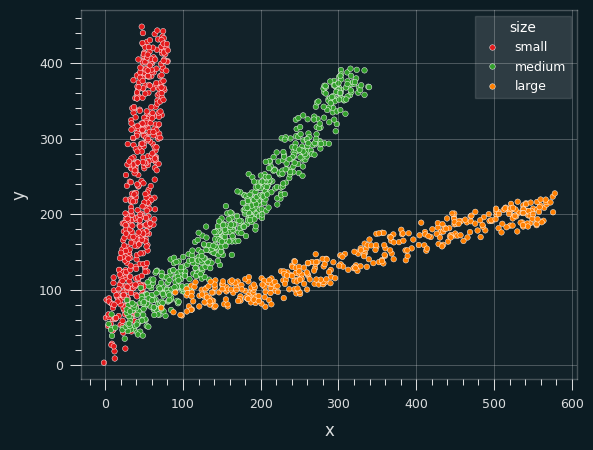

In [9]:
sns.scatterplot(data=df, x='x', y='y', hue='size')

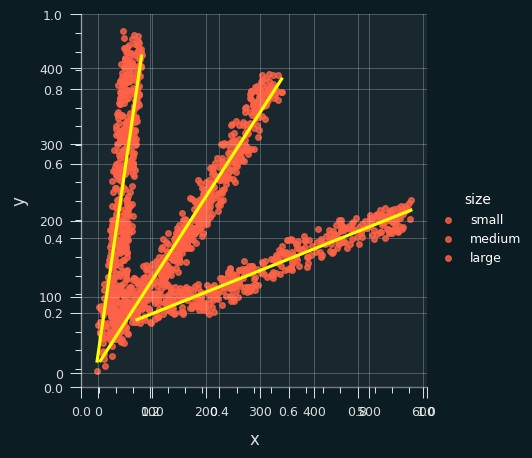

In [11]:
sns.lmplot(data=df, x='x', y='y',
           hue='size',
           scatter_kws={"color": "tomato"},
           line_kws={"color": "yellow"})

In [88]:
small, medium, large = 0, 1, 2
encodings = {"small": small, "medium": medium, "large": large}

df['encoded_size'] = df['size'].replace(encodings)
df['encoded_size'].unique()

C:\Users\daith\AppData\Local\Temp\ipykernel_10476\420967264.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['encoded_size'] = df['size'].replace(encodings)


array([0, 1, 2])

##### Run only once

In [101]:
# df = one_hot_encode_column(df, 'size')

In [103]:
df['small_fe'] = df['size_small'] * df['x']
df['medium_fe'] = df['size_medium'] * df['x']
df['large_fe'] = df['size_large'] * df['x']

In [104]:
df.head()

,x,y,color,label,size,encoded_size,size_large,size_medium,size_small,small_fe,medium_fe,large_fe
0,-1.730894,3.423839,#1f77b4,a,small,0,0,0,1,-1.730894,-0.0,-0.0
1,8.515065,28.519702,#1f77b4,a,small,0,0,0,1,8.515065,0.0,0.0
2,12.237016,8.971556,#1f77b4,a,small,0,0,0,1,12.237016,0.0,0.0
3,7.805157,26.929798,#1f77b4,a,small,0,0,0,1,7.805157,0.0,0.0
4,22.965298,43.212620,#1f77b4,a,small,0,0,0,1,22.965298,0.0,0.0


In [113]:
features = ['x', 'small_fe', 'medium_fe', 'large_fe', 'size_small', 'size_medium', 'size_large']
target = 'y'

X, y = df[features], df[target]

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [114]:
model_equation(model, features, target)

x1 = x
x2 = small_fe
x3 = medium_fe
x4 = large_fe
x5 = size_small
x6 = size_medium
x7 = size_large
y = y


'y = 1.56 * x1 + 3.31 * x2 - 0.46 * x3 - 1.28 * x4 - 4.21 * x5 - 16.93 * x6 + 21.14 * x7 + 28.46'

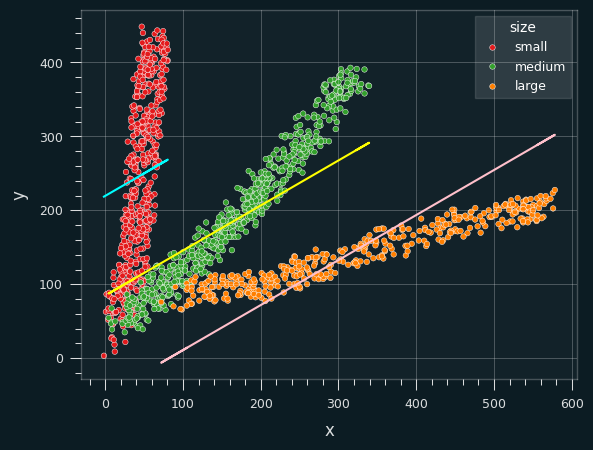

In [69]:
small_x = df[df['encoded_size'] == small][['x', 'encoded_size']]
medium_x = df[df['encoded_size'] == medium][['x', 'encoded_size']]
large_x = df[df['encoded_size'] == large][['x', 'encoded_size']]

w, b = model.coef_, model.intercept_

small_equation = small_x @ w + b
medium_equation = medium_x @ w + b
large_equation = large_x @ w + b


sns.scatterplot(data=df, x='x', y='y', hue='size')
plt.plot(small_x['x'], small_equation, color="cyan")
plt.plot(medium_x['x'], medium_equation, color="yellow")
plt.plot(large_x['x'], large_equation, color="pink")

In [70]:
small_y = df[df['encoded_size'] == small]['y']
medium_y = df[df['encoded_size'] == medium]['y']
large_y = df[df['encoded_size'] == large]['y']

small_acc = r2_score(small_y, model.predict(small_x))
medium_acc = r2_score(medium_y, model.predict(medium_x))
large_acc = r2_score(large_y, model.predict(large_x))

print(f"small class accuracy {small_acc * 100:.2f}")
print(f"medium class accuracy {medium_acc * 100:.2f}")
print(f"large class accuracy {large_acc * 100:.2f}")

small class accuracy 12.45
medium class accuracy 75.31
large class accuracy -31.69


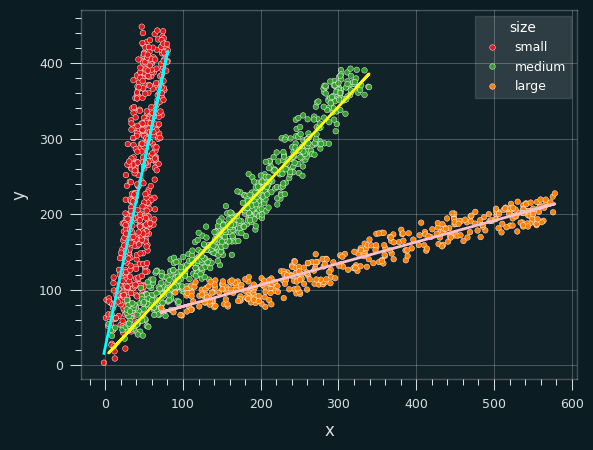

In [115]:
small_x = X[X['size_small'] == 1]
medium_x = X[X['size_medium'] == 1]
large_x = X[X['size_large'] == 1]

w, b = model.coef_, model.intercept_

small_equation = small_x @ w + b
medium_equation = medium_x @ w + b
large_equation = large_x @ w + b


sns.scatterplot(data=df, x='x', y='y', hue='size')
plt.plot(small_x['x'], small_equation, color="cyan", linewidth=2)
plt.plot(medium_x['x'], medium_equation, color="yellow", linewidth=2)
plt.plot(large_x['x'], large_equation, color="pink", linewidth=2)

In [116]:
small_y = df[df['encoded_size'] == small]['y']
medium_y = df[df['encoded_size'] == medium]['y']
large_y = df[df['encoded_size'] == large]['y']

small_acc = r2_score(small_y, model.predict(small_x))
medium_acc = r2_score(medium_y, model.predict(medium_x))
large_acc = r2_score(large_y, model.predict(large_x))

print(f"small class accuracy {small_acc * 100:.2f}")
print(f"medium class accuracy {medium_acc * 100:.2f}")
print(f"large class accuracy {large_acc * 100:.2f}")

small class accuracy 54.41
medium class accuracy 95.71
large class accuracy 91.90
